In [1]:
import csv
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI 
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
from collections import Counter
import igraph as ig
import pandas as pd
import numpy as np
import csv

from collections import Counter
from scipy.stats import binom 
from statistics import mean 
import seaborn as sns
import matplotlib.pyplot as plt

from h_louvain import hLouvain
from h_louvain import last_step

hnx.__version__

'2.1.3'

## Visualisation functions

In [2]:
def edge_statistics(edges_file):
    with open(edges_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))
    sizes = [len(Edges[i]) for i in range(len(Edges))]
    ctr_sizes = Counter(sizes)
    print("EDGE STATISTICS:")
    print("Mean size:",mean(sizes))
    print("Sizes counter:",dict(ctr_sizes))
    df = pd.DataFrame(sizes)
    df.columns = ['size']
    plt.figure(figsize=(9,4))
    sns.countplot(x = "size", data = df)
    plt.show()

def comm_statistics(comm_file):
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]

    print("COMMUNITIES STATISTICS:")
    community_sizes = [len(A_gt[i]) for i in range(len(A_gt))]
    print("Number of communities", len(A_gt))
    print("Mean size:", mean(community_sizes), "min size:", min(community_sizes), "max size:", max(community_sizes) )
    print("Sizes", community_sizes)
    
    
def edges_in_ground_truth_community(edge_file,partitions, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    print("")
    print("EDGES IN A GROUND-TRUTH COMMUNITY")
    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    edge_comm = []    
    for e in Edges:
        size = len(e)
        biggest = Counter([gt[int(i)-1] for i in e]).most_common(1)[0][1]
        edge_comm.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})


    to_display = {}
    to_display["lambda"] = []
    xs = np.linspace(0.501,1, 500)
    for x in xs:
        to_display["lambda"].append(x)
        
    if show_aggr == 1:
        to_display["aggr"] = []
    edges2show = []
        
    if show_edge_sizes == 'all':
        edges2show = list(set([len(e) for e in Edges]))
    else:
        edges2show = list(edge_sizes_to_show)  
        
    edges2show = sorted(edges2show)
        
        
    for i in edges2show:
        to_display[i] = []

    for x in xs:
        to_display["aggr"].append(sum(list(a["ratio"]>=x for a in edge_comm)))

    for i in edges2show:
        for x in xs:
            to_display[i].append(sum(list(a["ratio"]>=x and a["size"]==i for a in edge_comm)))

    plt.figure(figsize=(9,5))
    plt.ylim(0, to_display["aggr"][0]+50)
    
    plt.title("Number of edges captured by the partition")
    plt.xlabel("Percentage of nodes in the edge")
    plt.ylabel("Number of edges")
    df = pd.DataFrame(to_display)  
    if show_aggr == 1:
        sns.lineplot(data=df, x = "lambda", y = "aggr", label = "all sizes")
    
    for i in edges2show:
        sns.lineplot(data=df, x = "lambda", y = i, label = "size "+str(i))
        
    plt.show()
    return df, edge_comm



    
    
    #return 0
    
def visualise_case(edge_file,comm_file, show_aggr = 1, show_edge_sizes = 'all', edge_sizes_to_show = {}):
    edge_statistics(edge_file)
    comm_statistics(comm_file)
    df = edges_in_ground_truth_community(edge_file,comm_file, show_aggr=show_aggr,
                           show_edge_sizes = show_edge_sizes, edge_sizes_to_show = edge_sizes_to_show)
    return df

## Loading the graph

In [14]:
def load_ABCDH_from_file(filename):
    with open(filename,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(list(line))

    HG = hnx.Hypergraph(dict(enumerate(Edges)))
    return HG

In [15]:
HG = load_ABCDH_from_file("datasets/hg-linear_he.txt")


EDGE STATISTICS:
Mean size: 2.641053787047201
Sizes counter: {2: 515, 3: 245, 4: 114, 5: 37}


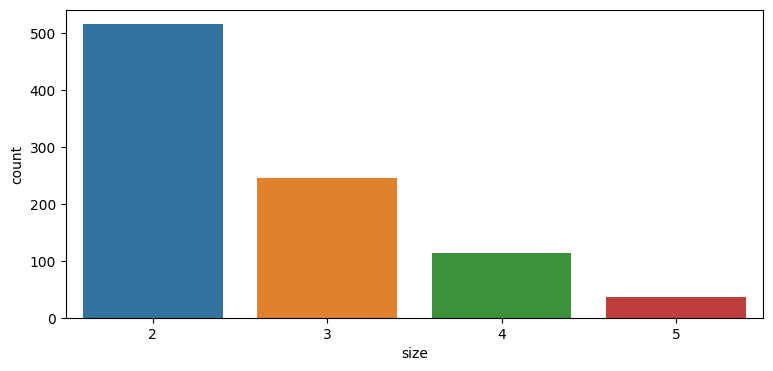

COMMUNITIES STATISTICS:
Number of communities 18
Mean size: 16.666666666666668 min size: 10 max size: 28
Sizes [28, 25, 25, 22, 22, 19, 18, 15, 15, 14, 14, 14, 13, 12, 12, 11, 11, 10]

EDGES IN A GROUND-TRUTH COMMUNITY


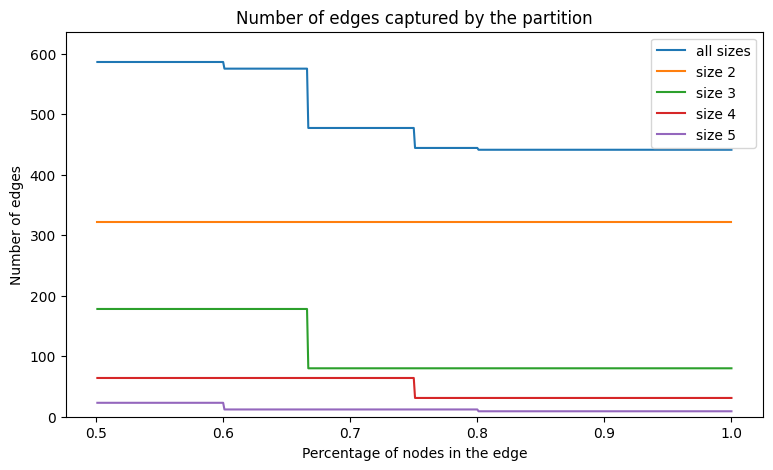

In [16]:
comm_file = "datasets/hg-linear_assign.txt"
edge_file = "datasets/hg-linear_he.txt"

print("")
df = visualise_case(edge_file,comm_file)

## Examples o usage

In [17]:
import h_louvain as hl
from h_louvain import last_step
from h_louvain_BO import hLouvainBO

In [18]:
hL = hl.hLouvain(HG,hmod_type=hmod.linear, 
                                    delta_it = 0.0001, 
                                    delta_phase = 0.0001, 
                                    random_seed = 5673) 

### hLouvain without last steps (any)

In [21]:
alphas = []
d = 0
c = 0.3
b = 0.8
for i in range(30):
    alphas.append(1-((1-b)**i)*(1-d))
    
print("alphas", alphas)

#### No forcing alpha = 1 at the end

A, q2, alphas_out = hL.h_louvain_community(alphas = alphas, force_alpha_1 = False,
                                                change_mode="communities", change_frequency=c)
qH = hL.combined_modularity(A, hmod.linear, 1)

print("alphas_out", alphas_out)

print("partition",A)
print("gH =",qH)

alphas [0.0, 0.8, 0.96, 0.992, 0.9984, 0.99968, 0.999936, 0.9999872, 0.99999744, 0.999999488, 0.9999998976, 0.99999997952, 0.999999995904, 0.9999999991808, 0.99999999983616, 0.999999999967232, 0.9999999999934464, 0.9999999999986893, 0.9999999999997379, 0.9999999999999476, 0.9999999999999896, 0.9999999999999979, 0.9999999999999996, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alphas_out [0.0, 0.8, 0.96]
partition [{'238', '211', '74', '190', '297', '179', '80', '276', '43', '93', '103', '50', '284', '66', '241', '149', '57', '169', '213'}, {'98', '106', '138', '157', '178', '267', '23', '208', '86', '115', '164', '132', '257', '146', '214', '30', '273', '289', '42', '279', '184', '107'}, {'242', '1', '181', '153', '194', '282', '248', '54', '17', '218', '150', '11', '25'}, {'5', '139', '295', '278', '219', '183', '91', '76', '215', '8', '160', '52', '260', '232', '281', '39', '239'}, {'294', '163', '99', '59', '69', '170', '10', '296', '36', '47', '142'}, {'243', '259', '159', '120

### hLouvain with cheap last step (default)

In [22]:
## default value force_alpha_1 = True

A, q2, alphas_out = hL.h_louvain_community(alphas = alphas, 
                                                change_mode="communities", change_frequency=c)
qH = hL.combined_modularity(A, hmod.linear, 1)

print("alphas_out", alphas_out)

print("partition",A)
print("gH =",qH)

alphas_out [0.0, 0.8, 0.96, 1]
partition [{'238', '211', '74', '190', '297', '179', '80', '276', '43', '93', '103', '50', '284', '66', '241', '149', '57', '169', '213'}, {'98', '106', '138', '157', '178', '267', '23', '208', '86', '115', '164', '132', '257', '146', '214', '30', '273', '289', '42', '279', '184', '107'}, {'242', '1', '181', '153', '194', '282', '248', '54', '17', '218', '150', '11', '25'}, {'5', '139', '295', '278', '219', '183', '91', '76', '215', '8', '160', '52', '260', '232', '281', '39', '239'}, {'294', '163', '99', '59', '69', '170', '95', '10', '296', '222', '36', '47', '142'}, {'243', '259', '159', '120', '38', '101', '19', '171', '204', '55', '111', '7', '196'}, {'141', '189', '209', '68', '16', '110', '71', '41', '28', '268', '123', '87', '119', '34', '92', '154', '230', '90', '226', '83', '121', '250', '198', '89', '280', '185'}, {'288', '114', '210', '251', '109', '85', '223', '229', '72', '247', '152', '12', '151', '143', '173', '78', '128', '116', '18', '22

In [23]:
Als, A, alphas_out = hL.h_louvain_community_plus_last_step(alphas = alphas, 
                                                change_mode="communities", change_frequency=c)
qH = hL.combined_modularity(A, hmod.linear, 1)

qH1 = hL.combined_modularity(Als, hmod.linear, 1)

print("alphas_out", alphas_out)

print("partition",A)
print("gH =",qH)

print("partition",Als)
print("gH1 =",qH1)

alphas_out [0.0, 0.8, 0.96, 1]
partition [{'238', '211', '74', '190', '297', '179', '80', '276', '43', '93', '103', '50', '284', '66', '241', '149', '57', '169', '213'}, {'98', '106', '138', '157', '178', '267', '23', '208', '86', '115', '164', '132', '257', '146', '214', '30', '273', '289', '42', '279', '184', '107'}, {'242', '1', '181', '153', '194', '282', '248', '54', '17', '218', '150', '11', '25'}, {'5', '139', '295', '278', '219', '183', '91', '76', '215', '8', '160', '52', '260', '232', '281', '39', '239'}, {'294', '163', '99', '59', '69', '170', '95', '10', '296', '222', '36', '47', '142'}, {'243', '259', '159', '120', '38', '101', '19', '171', '204', '55', '111', '7', '196'}, {'141', '189', '209', '68', '16', '110', '71', '41', '28', '268', '123', '87', '119', '34', '92', '154', '230', '90', '226', '83', '121', '250', '198', '89', '280', '185'}, {'288', '114', '210', '251', '109', '85', '223', '229', '72', '247', '152', '12', '151', '143', '173', '78', '128', '116', '18', '22

## hLouvainBO examples

In [24]:
hBO = hLouvainBO(HG,hmod_type=hmod.linear, 
                                    delta_it = 0.0001, 
                                    delta_phase = 0.0001, 
                                    random_seed = 8771) 

### Setting parameters
default one:

    seeds = [1234,5325,5467,4723,999,989,1245, 432,1904,7633] #number of repetitions in BO function
    xi =1e-3,
    init_points=5,
    n_iter=5,
    pbounds = {'b': (0,1), 'c': (0.01,0.99)},
    bomode = "last_step",  # last step calculated for the best results;;;  other: "basic" - without last step, or "last step all" - last step calculated for every single calculation
    last_step_top_points = 1,   # number of best results for which the expensive last step will be performed
    hmod_type = hmod.linear,
    show_bo_table = True,
    weights = "standard",  #if weights are "custom" then we can optimize custom modularity weights
    custom_weights_array = [],

In [34]:
## setting params: 
hBO.set_params(bomode="last_step")
result_df = hBO.hLouvain_perform_BO()
print(result_df)

|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.5242    | 0.8434    | 0.7347    |
| 2         | 0.5206    | 0.01308   | 0.8844    |
| 3         | 0.5237    | 0.9026    | 0.6617    |
| 4         | 0.5248    | 0.6366    | 0.6464    |
| 5         | 0.5253    | 0.8828    | 0.5412    |
| 6         | 0.5212    | 0.08125   | 0.345     |
| 7         | 0.5256    | 0.8896    | 0.5282    |
| 8         | 0.5252    | 0.8888    | 0.5261    |
| 9         | 0.5247    | 0.901     | 0.5406    |
| 10        | 0.5253    | 0.8835    | 0.5423    |
           b         c  seed #com        qH  \
79  0.888836  0.526122  7633   14  0.531019   

                                               alphas  \
79  [0.0, 0.8888358252334136, 0.9876425262484638, ...   

                                                    A  \
79  [{37, 256, 9, 158, 61, 27, 199, 253, 263, 133,...   

                                              A_lstep  qH_lstep  
79  [{37,

In [35]:
print(result_df[["b","c","#com",'qH','qH_lstep']])

           b         c #com        qH  qH_lstep
79  0.888836  0.526122   14  0.531019  0.533319


In [31]:
## other settings

hBO.set_params(bomode="last_step", seeds = [1,56,2424], init_points = 3, n_iter = 5, last_step_top_points = 5)
result_df2 = hBO.hLouvain_perform_BO()

print(result_df2[["b","c","#com",'qH','qH_lstep']])

|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.5193    | 0.8434    | 0.7347    |
| 2         | 0.5209    | 0.01308   | 0.8844    |
| 3         | 0.5187    | 0.9026    | 0.6617    |
| 4         | 0.5209    | 0.08125   | 0.345     |
| 5         | 0.5198    | 0.03752   | 0.6098    |
| 6         | 0.5237    | 0.8417    | 0.2455    |
| 7         | 0.524     | 0.8235    | 0.13      |
| 8         | 0.5245    | 0.6825    | 0.8567    |
           b         c #com        qH  qH_lstep
16  0.841708  0.245537   15  0.529192  0.529709
1   0.843394  0.734679   15  0.526464  0.532083
23  0.682544  0.856697   15  0.526225  0.530338
21  0.682544  0.856697   15  0.526225  0.530199
19  0.823533  0.130020   15  0.526170  0.528005


### Checking AMI and ARI

In [33]:
def getAMI_ARI(HG,gt,A):
    d = hmod.part2dict(A)
    A4ari = [d[str(i+1)] for i in range(len(HG.nodes))]
    return AMI(gt, A4ari), ARI(gt, A4ari)

G = hmod.two_section(HG)
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ML = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

with open(comm_file, 'r') as file:
    gt = [int(line) for line in file]
A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]



print("2-section (ML) (AMI,ARI):", getAMI_ARI(HG,gt,ML),"no of com", len(ML))


2-section (ML) (AMI,ARI): (0.8744774822749787, 0.7767230972769239) no of com 14


### check for our 2-section

In [36]:
alphas = [0]
ourML, q2, alphas_out = hL.h_louvain_community(alphas = alphas, force_alpha_1 = False,
                                                change_mode="communities", change_frequency=c)
print("2-section (ML) (AMI,ARI):", getAMI_ARI(HG,gt,ourML),"no of com", len(ourML))

2-section (ML) (AMI,ARI): (0.8920579673561404, 0.7843660141277056) no of com 14


### check for hLouvainBO best

In [39]:
sorted_results = result_df.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("linear (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))

linear (AMI,ARI): (0.8152257667930622, 0.7105364672604746) no of com 14


## Optimizing rho

In [41]:



def edges_in_gt(edge_file,comm_file):

    with open(comm_file, 'r') as file:
        gt = [int(line) for line in file]
        A_gt = [x for x in hmod.dict2part({str(i+1):gt[i] for i in range(len(gt))}) if len(x)>0]
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    edge_comm = []    
    for e in Edges:
        size = len(e)
        biggest = Counter([gt[int(i)-1] for i in e]).most_common(1)[0][1]
        edge_comm.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
    
    cds = {}
    
    sizes = [len(Edges[i]) for i in range(len(Edges))]
    max_sizes = max(sizes)
    cds_array = np.zeros((max_sizes+1,max_sizes+1))
    for edge in edge_comm:
        if 2*edge['biggest'] > edge['size']:
            cds_array[edge['biggest'],edge['size']]+=1
            if str(edge['biggest'])+"-"+str(edge['size']) in cds.keys():
                cds[str(edge['biggest'])+"-"+str(edge['size'])]+=1
            else:
                cds[str(edge['biggest'])+"-"+str(edge['size'])]=1                            

    return cds, cds_array, A_gt


def edges_in_partition(edge_file,A,HG):

    d = hmod.part2dict(A)
    part = [d[str(i+1)] for i in range(len(HG.nodes))]
    with open(edge_file,"r") as f:
        rd = csv.reader(f)
        lines = list(rd)
    Edges = []
    for line in lines:
        Edges.append(set(line))

    edge_comm = []    
    for e in Edges:
        size = len(e)
        biggest = Counter([part[int(i)-1] for i in e]).most_common(1)[0][1]
        edge_comm.append({'size': size, 'biggest': biggest, 'ratio': biggest/size})
    
    cds = {}
    
    sizes = [len(Edges[i]) for i in range(len(Edges))]
    max_sizes = max(sizes)
    cds_array = np.zeros((max_sizes+1,max_sizes+1))
    for edge in edge_comm:
        if 2*edge['biggest'] > edge['size']:
            cds_array[edge['biggest'],edge['size']]+=1
            if str(edge['biggest'])+"-"+str(edge['size']) in cds.keys():
                cds[str(edge['biggest'])+"-"+str(edge['size'])]+=1
            else:
                cds[str(edge['biggest'])+"-"+str(edge['size'])]=1                            

    return cds, cds_array

 
    
def set_weights(nums_edges, rho):
    weights = np.zeros((nums_edges.shape[0],nums_edges.shape[1]))

    total_sum = nums_edges.sum(axis=0)
   # print(total_sum)
    for d in range(2,nums_edges.shape[1]):
        temp_sum = 0
        if total_sum[d] > 0:
            for c in np.arange(int(np.floor(d / 2 + 1)), d + 1):
                temp_sum +=nums_edges[c,d]
                weights[c,d] = (rho + temp_sum/total_sum[d])/(rho+1)
    return weights


In [44]:

edge_weights_gt, gt_array, A_gt = edges_in_gt(edge_file,comm_file)

print("GT")
print(edge_weights_gt)
        
print(gt_array)

G = hmod.two_section(HG)
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ML = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

print("")
print("ML")
edge_weights_A, ew_array = edges_in_partition(edge_file,ML,HG)
print(edge_weights_A)
       
print(ew_array)
#print(set_weights(ew_array,0))
#print(set_weights(ew_array,0.25))
#print(set_weights(ew_array,0.5))
#print(set_weights(ew_array,0.75))
#print(set_weights(ew_array,1))



GT
{'2-2': 321, '4-4': 31, '2-3': 98, '3-3': 80, '3-5': 11, '3-4': 33, '5-5': 9, '4-5': 3}
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 321.  98.   0.   0.]
 [  0.   0.   0.  80.  33.  11.]
 [  0.   0.   0.   0.  31.   3.]
 [  0.   0.   0.   0.   0.   9.]]

ML
{'2-2': 332, '4-4': 30, '2-3': 93, '3-3': 90, '3-4': 36, '5-5': 10, '3-5': 8, '4-5': 4}
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 332.  93.   0.   0.]
 [  0.   0.   0.  90.  36.   8.]
 [  0.   0.   0.   0.  30.   4.]
 [  0.   0.   0.   0.   0.  10.]]


In [47]:
rho = 0.1

print("rho", rho)
print("")

edge_weights_A, ew_array = edges_in_partition(edge_file,ML,HG)

hBO.set_params(weights = "custom", custom_weights_array = set_weights(ew_array,rho), bomode="last_step")
first_step_1_1 = hBO.hLouvain_perform_BO()

sorted_results = first_step_1_1.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("first step (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))
    
edge_weights_A, ew_array2 = edges_in_partition(edge_file,best_A[0],HG)

hBO.set_params(weights = "custom", custom_weights_array = set_weights(ew_array2,rho), bomode="last_step")
first_step_1_2 = hBO.hLouvain_perform_BO()
sorted_results = first_step_1_2.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("second step (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))

rho 0.1

|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.5035    | 0.4067    | 0.7459    |
| 2         | 0.5039    | 0.713     | 0.8387    |
| 3         | 0.5072    | 0.4876    | 0.4912    |
| 4         | 0.5055    | 0.663     | 0.4594    |
| 5         | 0.5095    | 0.7731    | 0.111     |
| 6         | 0.5088    | 0.2131    | 0.3005    |
| 7         | 0.5088    | 0.6429    | 0.2337    |
| 8         | 0.5096    | 0.7549    | 0.1183    |
| 9         | 0.508     | 0.5737    | 0.01      |
| 10        | 0.508     | 0.0       | 0.05918   |
first step (AMI,ARI): (0.8570234423116372, 0.7438029451785947) no of com 14
|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.5105    | 0.4067    | 0.7459    |
| 2         | 0.5101    | 0.713     | 0.8387    |
| 3         | 0.5123    | 0.4876    | 0.4912    |
| 4         | 0.5122    | 0.663     | 0.4594    |
| 5         | 0

In [50]:
print("strict")
print("")

hBO.set_params(bomode="last_step", hmod_type = hmod.strict)
strict = hBO.hLouvain_perform_BO()
sorted_results = strict.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("strict (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))

strict

|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.4574    | 0.4067    | 0.7459    |
| 2         | 0.4326    | 0.713     | 0.8387    |
| 3         | 0.4624    | 0.4876    | 0.4912    |
| 4         | 0.4603    | 0.663     | 0.4594    |
| 5         | 0.4641    | 0.7731    | 0.111     |
| 6         | 0.4619    | 0.5611    | 0.2249    |
| 7         | 0.4624    | 0.6429    | 0.2337    |
| 8         | 0.4636    | 0.1229    | 0.5468    |
| 9         | 0.4637    | 1.0       | 0.01      |
| 10        | 0.4637    | 0.0       | 0.8895    |
strict (AMI,ARI): (0.7766536181751086, 0.5731722095513936) no of com 9


In [51]:
print("majority")
print("")


hBO.set_params(bomode="last_step", hmod_type = hmod.majority)
majority = hBO.hLouvain_perform_BO()

sorted_results = majority.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("majority (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))

majority

|   iter    |  target   |     b     |     c     |
-------------------------------------------------
| 1         | 0.568     | 0.4067    | 0.7459    |
| 2         | 0.5576    | 0.713     | 0.8387    |
| 3         | 0.5718    | 0.4876    | 0.4912    |
| 4         | 0.5668    | 0.663     | 0.4594    |
| 5         | 0.5642    | 0.7731    | 0.111     |
| 6         | 0.5714    | 0.412     | 0.5468    |
| 7         | 0.5672    | 0.6429    | 0.2337    |
| 8         | 0.5681    | 0.3678    | 0.359     |
| 9         | 0.5655    | 0.08658   | 0.6995    |
| 10        | 0.5543    | 0.9028    | 0.9486    |
majority (AMI,ARI): (0.7482871126948113, 0.6445738851555671) no of com 15


In [ ]:
print("linear")
print("")

hBO.hmod_type = hmod.linear
hBO.set_params(bomode="last_step", hmod_type = hmod.linear)
linear = hBO.hLouvain_perform_BO()

sorted_results = linear.sort_values(by = ["qH_lstep"],  ascending=False)
best_A = sorted_results["A_lstep"].tolist()

for i in range(hBO.last_step_top_points):
    print("linear (AMI,ARI):", getAMI_ARI(HG,gt,best_A[i]),"no of com", len(best_A[i]))
    
    